In [1]:
import numpy as np
import rdkit as rd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity

In [2]:
#Determines if SMILES is valid or not
def is_valid(smiles):
    
    mol = Chem.MolFromSmiles(smiles)

    #Returns True if SMILES is valid, returns False if SMILES is invalid
    return smiles != '' and mol is not None and mol.GetNumAtoms() > 0

In [3]:
#Determines LogP
def logP(smiles):
    
    return(Descriptors.MolLogP(Chem.MolFromSmiles(smiles)))

In [4]:
#Determins molecular weight
def molWt(smiles):
    
    return(Descriptors.MolWt(Chem.MolFromSmiles(smiles)))

In [5]:
#Determine number hydrogen bond acceptors
def numAcc(smiles):
    
    return(Descriptors.NumHAcceptors(Chem.MolFromSmiles(smiles)))

In [6]:
#Determine number hydrogen bond donors
def numDon(smiles):
    
    return(Descriptors.NumHDonors(Chem.MolFromSmiles(smiles)))

In [7]:
#Determine polar surface area
def polSur(smiles):
    
    return(Descriptors.TPSA(Chem.MolFromSmiles(smiles)))

In [8]:
#Determine number of rotatable bonds
def rolBon(smiles):
    return(Descriptors.NumRotatableBonds(Chem.MolFromSmiles(smiles)))

In [9]:
#Number of characters generated
num_characters = 0

#Number of molecules generated
num_smiles = 0

#Number of unique SMILES
num_unq_mols = 0

#Number of unique SMILES that aren't in the training data
num_mols = 0

#Number of valid molecules that aren't in the training data generated
num_valid = 0

#List of smiles in file, to make sure smiles are unique
smileslist = []

In [11]:
#Test how many molecules are valid (without considering uniqueness, novelty)
total = 0
number_valid = 0

#Read in data file line by line
for line in open("3generatedsmiles0.5.txt", "r"):
    total += 1
    
    #Ensure smiles are valid
    if(is_valid(line) == True):
                           
        #Increment number of valid molecules generated
        number_valid += 1

print("Percent valid molecules: " + str(number_valid / total * 100))

Percent valid molecules: 90.41680296587067


In [12]:
#Training data
training_data = list(open("smiles.txt", "r"))

#File with unique generated SMILES that aren't in the training data
generatedmols = open("3generatedmols.txt", "w")

#Read in data file line by line
for line in open("3generatedsmiles0.5.txt", "r"):
    
    #Ensure molecules are unique
    if line not in smileslist:
        
        smileslist.append(line)
        
        num_unq_mols += 1

        #Ensure smiles aren't in training data
        if line not in training_data:  

            #Remove \n character, remove G character
            smiles = line.replace("\n", "").replace("G", "")
            
            #Increment number of molecules generated
            num_mols += 1

            #Ensure smiles are valid
            if(is_valid(smiles) == True):
            
                #Copy over SMILES satisfying requirements
                generatedmols.write(smiles + "\n")
                
                #Increment number of valid molecules generated
                num_valid += 1
                
    #Increment total number of SMILES generated
    num_smiles += 1
    
    #Add length of line to total number of characters
    num_characters += len(line)

In [13]:
print("Number of characters generated: " + str(num_characters))
print("Number of molecules generated: " + str(num_smiles))
print("Number of unique molecules generated: " + str(num_unq_mols))
print("Number of novel and unique molecules generated: " + str(num_mols))
print("Number of novel, unique, and valid molecules generated: " + str(num_valid))

Number of characters generated: 9779921
Number of molecules generated: 220104
Number of unique molecules generated: 4764
Number of novel and unique molecules generated: 4764
Number of novel, unique, and valid molecules generated: 2497


In [14]:
#List of Morgan fingerprints of molecules
fingerprints = []

#Read in data file line by line
for line in open("3generatedmols.txt", "r"):
    
    #Convert SMILES string to Morgan fingerprint
    mol = Chem.MolFromSmiles(line.replace("\n", ""))
    fingerprint = AllChem.GetMorganFingerprint(mol, 2)
    
    #Add to list of fingerprints
    fingerprints.append(fingerprint)    

In [15]:
#Total Tanimoto Distance
tanimoto = 0

#Calculate Tanimoto Distance between each pair of fingerprints
for fpt1 in fingerprints:
    for fpt2 in fingerprints:
        
        if fpt1 != fpt2:
            
            #Calculate Tanimoto Similarity
            tan = TanimotoSimilarity(fpt1, fpt2)
            tanimoto += tan

#Average Tanimoto Similarity
avg_tanimoto = (1 / (num_valid * (num_valid - 1))) * tanimoto
print("Average Tanimoto Similarity: {:0.4f}".format(avg_tanimoto))

Average Tanimoto Similarity: 0.1475


In [16]:
#Array of molecular properties for generated molecules
molProps = np.empty((0,5))

#Read in data file line by line
for molecule in open("3generatedmols.txt", "r"):
    try:
        #Array of properties [partition coefficient, molecular weight, number of hydrogen bond acceptors, number of hydrogen bond donors, number of rotatable bonds]
        props = np.reshape(np.array([logP(molecule), molWt(molecule), numAcc(molecule), numDon(molecule), rolBon(molecule)]), (1, 5))
    
        #Append properties
        molProps = np.append(molProps, props, axis=0)
        
    except:
        #Occasionally RDKit bugs don't allow for analyzing the molecule; in these cases, simply remove the molecule
        molecule.replace(molecule, "")
        continue

In [17]:
#Array of number of molecules each molecule is dominated by
dom = np.zeros((np.shape(molProps)[0]))

#Analyze each molecule's properties as they compare to others
for i in range(np.shape(molProps)[0]):
    
    for j in range(np.shape(molProps)[0]):
        
        #Compare each property between the molecules
        if (molProps[j, 0] <= molProps[i, 0]):
            
            if (molProps[j, 1] <= molProps[i, 1]):
            
                if (molProps[j, 2] <= molProps[i, 2]):

                    if (molProps[j, 3] <= molProps[i, 3]):
            
                        if (molProps[j, 4] <= molProps[i, 4]):
                            
                            #If molecule j is better than molecule i in every property, than j dominates i
                            dom[i] += 1

In [18]:
#Count how many frontiers there are and how many molecules are in each frontier
unique, counts = np.unique(dom, return_counts=True)
fronts = dict(zip(unique, counts))

#Indices of best molecules for use in finetuning
fineMols = np.empty((0,1))

#Fraction of molecules to be used for transfer learning
top = 0.5

#Frontier iterator 
f = 0
#Get indices of the best (top) fraction of molecules
while(np.shape(fineMols)[0] < (top * np.shape(molProps)[0])):

    #Indices of molecules in frontier i
    fineMolecules = np.transpose(np.where(dom == f))
    
    #Add to finemols
    fineMols = np.append(fineMols, fineMolecules, axis=0)
      
    #Look at next worst frontier
    f += 1

In [19]:
#Save best molecules to transferdata.txt
transferdata = open("3transferdata.txt", "w")

#Index counter
i = 0

#Get best molecules and save them to transferdata.txt
for line in open("3generatedmols.txt", "r"):
    
    #Get best molecules, write to new file
    if i in fineMols:
        
        #Append start token
        line = line.rjust(len(line)+1, "G")
        
        #Write to file
        transferdata.write(line)
    
    i += 1

#Close file
transferdata.close()

In [20]:
#Array of molecular properties for generated molecules
transferMolProps = np.empty((0,5))

#Read in data file line by line
for molecule in open("3transferdata.txt", "r"):
    
    #Remove start token to analyze molecules
    molecule = molecule.replace("G", "")
    
    #Array of properties [partition coefficient, molecular weight, number of hydrogen bond acceptors, number of hydrogen bond donors, number of rotatable bonds]
    transferProp = np.reshape(np.array([logP(molecule), molWt(molecule), numAcc(molecule), numDon(molecule), rolBon(molecule)]), (1, 5))
    
    #Append properties
    transferMolProps = np.append(transferMolProps, transferProp, axis=0)

In [21]:
#Read in original training data file to get character list
data = open("smiles.txt", "r").read()

#Create a list of the unique characters in the dataset
chars = list(set(data))

In [22]:
from numpy import argmax
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Create array from characters in the dataset
values = array(chars)
valueslist = values.tolist()
print("Array of unique characters:")
print(values)

#Create unique, numerical labels for each character between 0 and n-1, where n is the number of unique characters
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print("Array of labels for each character:")
print(integer_encoded)

#Encode characters into a one-hot encoding, resulting in an array of size [num unique chars, num unique chars]
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("Array of one-hot encoded characters:")
print(onehot_encoded)
print("Size of array of one-hot encoded characters: " + str(onehot_encoded.shape))

Array of unique characters:
[')' 'S' '\n' 'K' '+' 'i' 't' '8' '-' 'L' '#' 'O' 'R' '1' 'C' '9' 'g' 'B'
 'I' 'p' '/' 'V' 'r' 'A' '.' '(' 'n' 'o' '[' ']' '6' 'c' 'a' 'e' 'T' '5'
 '3' 'F' 'P' 'Z' 'G' '=' 'H' '7' '@' 'M' 'l' '2' '\\' 'N' 'b' 's' '4']
Array of labels for each character:
[ 3 33  0 26  4 45 52 15  5 27  1 30 32  8 21 16 44 20 25 49  7 35 50 19
  6  2 47 48 37 39 13 42 40 43 34 12 10 22 31 36 23 17 24 14 18 28 46  9
 38 29 41 51 11]
Array of one-hot encoded characters:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Size of array of one-hot encoded characters: (53, 53)


C:\Users\jake\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [41]:
#Read in transfer data file
data = open("3transferdata.txt", "r").read()
#Create a list of the dataset, along with all the characters to ensure they are all represented
datalist = list(data)
datalist.extend(valueslist)
#Create an array of the dataset
dataarray = array(datalist)
#Fit one-hot encoding to dataarray
dataarray = dataarray.reshape(len(dataarray), 1)
#Fit encoder, remove all characters at the end leaving just the molecules
ohefinemols = onehot_encoder.fit_transform(dataarray).astype(int)
print("Size of one-hot encoded array of data: " + str(ohefinemols.shape))
print("One-hot encoded array of data:")
print(ohefinemols)

Size of one-hot encoded array of data: (54804, 53)
One-hot encoded array of data:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [24]:
#Save ohefinemols as a (compressed) file
np.savez_compressed("3ohefinemols.npz", ohefinemols)

In [25]:
#Create integer transfer data
intfinemols = [np.where(r==1)[0][0] for r in ohefinemols]

In [40]:
print(np.shape(intfinemols))

(31980,)


In [26]:
#Save intfinemols as a (compressed) file
np.savez_compressed("3intfinemols.npz", intfinemols)

In [27]:
#Array with SMILES character, integer encoding, and one hot encoding (vocabulary)
values = np.reshape(values, (np.shape(values)[0], 1))
vocab = np.concatenate((values, integer_encoded.astype(object)), axis = 1)
vocab = vocab[vocab[:,1].argsort()]
vocabvalues = np.reshape(vocab[:,1], (-1,1))
vocabohe = onehot_encoder.fit_transform(vocabvalues)
vocabencodings = np.concatenate((vocab, vocabohe.astype(object)), axis = 1)
print(np.shape(vocabencodings))

(53, 55)


In [28]:
print(vocabencodings)

[['\n' 0 1.0 ... 0.0 0.0 0.0]
 ['#' 1 0.0 ... 0.0 0.0 0.0]
 ['(' 2 0.0 ... 0.0 0.0 0.0]
 ...
 ['r' 50 0.0 ... 1.0 0.0 0.0]
 ['s' 51 0.0 ... 0.0 1.0 0.0]
 ['t' 52 0.0 ... 0.0 0.0 1.0]]


In [29]:
#PCA visualization
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

#Scale array of properties for all molecules
scaledProps = StandardScaler().fit_transform(np.concatenate((molProps, transferMolProps), axis=0))

#Apply PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaledProps)

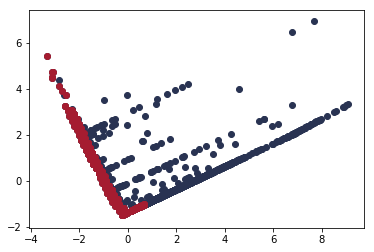

In [31]:
#Graph
import matplotlib.pyplot as plt

fig = plt.figure()
plt.scatter(principalComponents[0:np.shape(molProps)[0],0],principalComponents[0:np.shape(molProps)[0],1], color = "#293352")
plt.scatter(principalComponents[np.shape(molProps)[0]:,0],principalComponents[np.shape(molProps)[0]:,1], color = "#A51C30")
plt.show(fig)

In [46]:
fig.savefig("selectedmols.png", dpi=600)

In [39]:
totalcount = 0
worthy = 0
for i in range(int(np.shape(molProps)[0])):
    totalcount += 1
    if molProps[i,0] <= 3:
        if molProps[i,1] <= 480:
            if molProps[i,2] <= 3:
                if molProps[i,3] <= 3:
                    if molProps[i,4] <= 3:
                        worthy += 1
                        
print(worthy/totalcount)

0.06549324600900532
